# PARTIE 1 : Analyse exploratoire des données

## Import librairies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

## Lecture des données

In [2]:
data = pd.read_csv('./src/rentals_data.csv', sep=';')

In [3]:
print(data.shape)
data.isna().sum()/data.shape[0]*100

(21310, 7)


rental_id                                      0.000000
car_id                                         0.000000
checkin_type                                   0.000000
state                                          0.000000
delay_at_checkout_in_minutes                  23.294228
previous_ended_rental_id                      91.360863
time_delta_with_previous_rental_in_minutes    91.360863
dtype: float64

In [4]:
data.count()/len(data.index)

rental_id                                     1.000000
car_id                                        1.000000
checkin_type                                  1.000000
state                                         1.000000
delay_at_checkout_in_minutes                  0.767058
previous_ended_rental_id                      0.086391
time_delta_with_previous_rental_in_minutes    0.086391
dtype: float64

## Valeurs erronnées

In [5]:
data.drop([21002], axis=0, inplace=True)

In [6]:
data.rename(columns={'delay_at_checkout_in_minutes': 'delay', 
                     'previous_ended_rental_id': 'previous_id', 
                     'time_delta_with_previous_rental_in_minutes': 'time_gap'}, 
                      inplace = True)

In [7]:
df = data.copy()
df = df.fillna(0)

In [8]:
df['canceled'] = df['state'].apply(lambda x: 1 if x == 'canceled' else 0)
df['delayed'] = df['delay'].apply(lambda x: 1 if x > 0 else 0)
df['previous'] = df['previous_id'].apply(lambda x: 1 if x != 0 else 0)
df['previous_id'] = df['previous_id'].astype(int)

In [9]:
df.dtypes

rental_id         int64
car_id            int64
checkin_type     object
state            object
delay           float64
previous_id       int64
time_gap        float64
canceled          int64
delayed           int64
previous          int64
dtype: object

In [10]:
df.to_csv('./src/rentals_data_clean.csv', index=False)

## Statistiques basiques

In [116]:
df = pd.read_csv('./src/rentals_data_clean.csv')

In [10]:
df.describe(include='all')

,rental_id,car_id,checkin_type,state,delay,previous_id,time_gap,canceled,delayed,previous
count,21309.000000,21309.000000,21309,21309,21309.000000,21309.000000,21309.000000,21309.000000,21309.000000,21309.000000
unique,NaN,NaN,2,2,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,mobile,ended,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,17002,18045,NaN,NaN,NaN,NaN,NaN,NaN
mean,549712.438594,350029.218405,NaN,NaN,46.616406,47528.488667,24.129241,0.153175,0.441316,0.086395
std,13863.622290,58207.264418,NaN,NaN,870.206204,154608.854714,108.417324,0.360164,0.496556,0.280954
min,504806.000000,159250.000000,NaN,NaN,-22433.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,540613.000000,317639.000000,NaN,NaN,-16.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,550349.000000,368710.000000,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,560469.000000,394928.000000,NaN,NaN,41.000000,0.000000,0.000000,0.000000,1.000000,0.000000


In [11]:
print('Total parc voitures :', df['car_id'].nunique())
print()
print('Total locations :', df['rental_id'].nunique())
print('- dont mobile :', len(df[df['checkin_type']=='mobile']),'soit', round(len(df[df['checkin_type']=='mobile'])/df['checkin_type'].count()*100,2), '%')
print('- dont connect :', len(df[df['checkin_type']=='connect']), 'soit', round(len(df[df['checkin_type']=='connect'])/df['checkin_type'].count()*100,2), '%')
print()
print('Total annulations :', df['canceled'].sum(), 'soit', round(df['canceled'].sum()/df['canceled'].count()*100,2), '%')
print()
print('Total locations serrées :', df['previous'].sum(), 'soit', round(df['previous'].sum()/df['previous'].count()*100,2), '%')
print()
print('Total retards :', df['delayed'].sum(), 'soit', round(df['delayed'].sum()/df['delayed'].count()*100,2), '%')
print('Retard moyen :', round(df[df['delayed']==1]['delay'].mean()), 'minutes soit', round(df[df['delayed']==1]['delay'].mean()))
print('Délai de retour moyen:', round(df['delay'].mean()), 'minutes')

Total parc voitures : 8142

Total locations : 21309
- dont mobile : 17002 soit 79.79 %
- dont connect : 4307 soit 20.21 %

Total annulations : 3264 soit 15.32 %

Total locations serrées : 1841 soit 8.64 %

Total retards : 9404 soit 44.13 %
Retard moyen : 202 minutes soit 202
Délai de retour moyen: 47 minutes


## Analyse des locations serrées

Les locations serrées (tight_rentals) sont les locations qui succèdent une location dans un délai inférieur à 12 heures (previous=1).


In [117]:
tight_rentals = df[(df['previous'] == 1)]
tight_rentals_canceled = tight_rentals[tight_rentals['canceled'] == 1]
tight_rentals_ended = tight_rentals[tight_rentals['canceled'] == 0]

In [118]:
df_temp = df[['rental_id', 'delay']]
df_temp = df_temp.rename(columns={'delay': 'previous_delay'})

In [119]:
tight_rentals_enriched = pd.merge(tight_rentals, df_temp, left_on='previous_id', right_on='rental_id') 
tight_rentals_enriched.drop(['rental_id_y'], axis=1, inplace=True)
tight_rentals_enriched.rename(columns={'rental_id_x':'rental_id'}, inplace=True)
tight_rentals_enriched

,rental_id,car_id,checkin_type,state,delay,previous_id,time_gap,canceled,delayed,previous,previous_delay
0,511639,370585,connect,ended,-15.0,563782,570.0,0,0,1,136.0
1,519491,312389,mobile,ended,58.0,545639,420.0,0,1,1,140.0
2,521156,392479,mobile,ended,0.0,537298,0.0,0,0,1,0.0
3,525044,349751,mobile,ended,0.0,510607,60.0,0,0,1,-113.0
4,528808,181625,connect,ended,-76.0,557404,330.0,0,0,1,-352.0
...,...,...,...,...,...,...,...,...,...,...,...
1836,568049,381499,connect,canceled,0.0,562174,720.0,1,0,1,73.0
1837,568241,396409,mobile,canceled,0.0,566136,570.0,1,0,1,16.0
1838,568523,297973,mobile,ended,12.0,567121,240.0,0,1,1,-275.0
1839,569717,377312,mobile,ended,230.0,545045,90.0,0,1,1,22.0


In [6]:
tight_rentals_enriched[tight_rentals_enriched['delayed']==1]['previous_delay'].mean()

0.7980049875311721

In [16]:
tight_rentals_enriched['checkin_type'].value_counts()

checkin_type
mobile     1028
connect     813
Name: count, dtype: int64

In [17]:
print('Total locations serrées :', tight_rentals_enriched['rental_id'].nunique())
print('- parc voitures uniques :', tight_rentals_enriched['car_id'].nunique())
print()
print('- dont mobile :', tight_rentals_enriched['checkin_type'].value_counts()[0], 'soit',  round(tight_rentals_enriched['checkin_type'].value_counts()[0]/len(tight_rentals_enriched)*100,2), '%')
print('- dont connect :', tight_rentals_enriched['checkin_type'].value_counts()[1], 'soit',  round(tight_rentals_enriched['checkin_type'].value_counts()[1]/len(tight_rentals_enriched)*100,2), '%' )
print()
print('- dont maintenues :', tight_rentals_enriched['state'].value_counts()[0], 'soit',  round(tight_rentals_enriched['state'].value_counts()[0]/len(tight_rentals_enriched)*100,2), '%' )
print('- dont annulées :', tight_rentals_enriched['state'].value_counts()[1], 'soit',  round(tight_rentals_enriched['state'].value_counts()[1]/len(tight_rentals_enriched)*100,2), '%' )
print()
print('- dont loueur précédent en retard :', len(tight_rentals_enriched[tight_rentals_enriched['previous_delay']>0]), 'soit', round(len(tight_rentals_enriched[tight_rentals_enriched['previous_delay']>0])/len(tight_rentals_enriched)*100,2), '%')
print('- dont non impactées par le retard :', len(tight_rentals_enriched[tight_rentals_enriched['previous_delay'] <= tight_rentals_enriched['time_gap']]))
print('- dont impactées par le retard :', len(tight_rentals_enriched[tight_rentals_enriched['previous_delay'] > tight_rentals_enriched['time_gap']]))
print()
print('- délai loueur précédent moyen :', round(tight_rentals_enriched['previous_delay'].mean()), 'minutes')
print('- délai accordé moyen :', round(tight_rentals_enriched['time_gap'].mean()), 'minutes')
print()
print('Cas des annulations :')
print('- dont connect :', tight_rentals_enriched[tight_rentals_enriched['state']=='canceled']['checkin_type'].value_counts()[0], 'soit',  round(tight_rentals_enriched[tight_rentals_enriched['state']=='canceled']['checkin_type'].value_counts()[0]/len(tight_rentals_enriched[tight_rentals_enriched['state']=='canceled'])*100,2), '%')
print('- dont mobile :', tight_rentals_enriched[tight_rentals_enriched['state']=='canceled']['checkin_type'].value_counts()[1], 'soit',  round(tight_rentals_enriched[tight_rentals_enriched['state']=='canceled']['checkin_type'].value_counts()[1]/len(tight_rentals_enriched[tight_rentals_enriched['state']=='canceled'])*100,2), '%' )
print('- dont loueur précédent en retard :', len(tight_rentals_enriched[(tight_rentals_enriched['state']=='canceled') & (tight_rentals_enriched['previous_delay'] > 0)]))
print('- dont le retard est impactant :', len(tight_rentals_enriched[(tight_rentals_enriched['state']=='canceled') & (tight_rentals_enriched['previous_delay'] > tight_rentals_enriched['time_gap'])]))
print('- délai accordé moyen :', round(tight_rentals_enriched[tight_rentals_enriched['state']=='canceled']['time_gap'].mean()), 'minutes')
print('- délai loueur précédent moyen :', round(tight_rentals_enriched[tight_rentals_enriched['state']=='canceled']['previous_delay'].mean()), 'minutes')

Total locations serrées : 1841
- parc voitures uniques : 1087

- dont mobile : 1028 soit 55.84 %
- dont connect : 813 soit 44.16 %

- dont maintenues : 1612 soit 87.56 %
- dont annulées : 229 soit 12.44 %

- dont loueur précédent en retard : 873 soit 47.42 %
- dont non impactées par le retard : 1623
- dont impactées par le retard : 218

- délai loueur précédent moyen : -23 minutes
- délai accordé moyen : 279 minutes

Cas des annulations :
- dont connect : 131 soit 57.21 %
- dont mobile : 98 soit 42.79 %
- dont loueur précédent en retard : 106
- dont le retard est impactant : 37
- délai accordé moyen : 295 minutes
- délai loueur précédent moyen : -38 minutes


## Retards impactants

Nous avons dénombré 37 retards impactants, c'est-à-dire ayant provoqué l'annulation de la location suivante.

En moyenne ce retard est de 250 minutes soit un peu plus de 4 heures. Le record étant de 24 heures de retard.

In [7]:
canceled_because_of_previous = tight_rentals_enriched[(tight_rentals_enriched['state']=='canceled') & (tight_rentals_enriched['previous_delay'] > tight_rentals_enriched['time_gap'])]

print('Nombre de retards impactant :', len(canceled_because_of_previous))
print('Retard moyen :', round(canceled_because_of_previous['previous_delay'].mean()), 'minutes')
print('Retard médian :', round(canceled_because_of_previous['previous_delay'].median()), 'minutes')
print('Retard max :', round(canceled_because_of_previous['previous_delay'].max()), 'minutes')
print('Retard min :', round(canceled_because_of_previous['previous_delay'].min()), 'minute')

Nombre de retards impactant : 37
Retard moyen : 254 minutes
Retard médian : 153 minutes
Retard max : 1466 minutes
Retard min : 1 minute


In [84]:
impacting_delay = canceled_because_of_previous['previous_delay'].to_frame().reset_index()
impacting_delay = impacting_delay.drop(['index'], axis=1)
impacting_delay['previous_delay_hours'] = impacting_delay['previous_delay'].apply(lambda x: round(x/60,2))

Intervalle = [-3, 12]


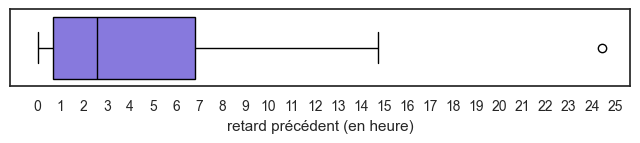

In [393]:
# Nous retirons les 2 valeurs aberrantes avant de faire la visualisation
mean_val = impacting_delay['previous_delay_hours'].mean()
std_val = impacting_delay['previous_delay_hours'].std()
print(f'Intervalle = [{round((mean_val - 1.5*std_val))}, {round((mean_val + 1.5*std_val))}]')

fig, ax = plt.subplots(figsize=(8, 1))
sns.boxplot(x=impacting_delay['previous_delay_hours'], ax=ax, palette=['mediumslateblue'], linecolor='black')
plt.xticks([i for i in range(0,26,1)], fontsize=10)
plt.xlabel('retard précédent (en heure)', fontsize=11)
plt.show()

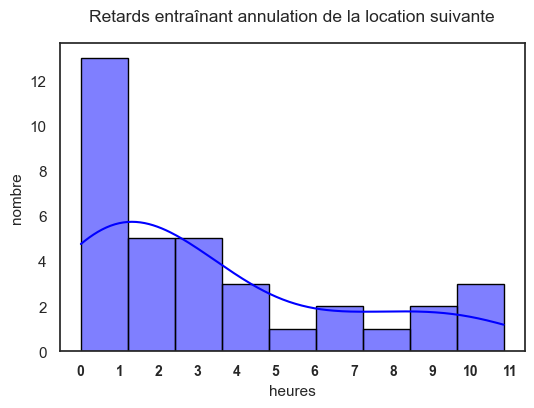

In [86]:
# Retards entraînant l'annulation de la location suivante 
sns.set(rc={"figure.figsize":(6, 4)}, style = 'white')
sns.histplot(data=impacting_delay[impacting_delay['previous_delay'] <= 720], x='previous_delay', kde=True, bins=9, edgecolor='black', color='blue')

plt.ylabel('nombre', fontsize=11)
plt.xlabel('heures', fontsize=11)

plt.xticks([i for i in range (0,720,60)], [i for i in range (0,12,1)], fontsize=10, fontweight='bold')
plt.title('Retards entraînant annulation de la location suivante', fontsize=12.5, pad=16)

plt.show()

La moitié des retards impactant sont inférieurs à 150 minutes soit 2,5 heures.

Définir un seuil à 2,5 heures permettrait de réduire de moitié les retards impactants.

Définir un seuil à 4 heures permettrait de réduire de deux tiers les retards impactants.

Avec un seuil de 4 heures nous n'aurions plus que 12 clients mécontents, contre 37 au départ.

In [403]:
print('Clients mécontents:', len(canceled_because_of_previous[canceled_because_of_previous['previous_delay'] > 240]))

Clients mécontents: 12


## Délai optimal entre deux locations

Pour trouver le délai optimal entre deux locations nous observons l'évolution du nombre de réservations et d'annulations suivant le délai choisi. 

Avant cela, nous pouvons déjà dire que si l'on définit un délai de 12 heures entre deux locations :

- on éviterait d'avoir 40 clients mécontents ; 

- on éviterait 230 annulations liées à un délai trop serré ;

- on perdrait 1840 réservations.


In [120]:
threshold = []
loss_rentals = []
cancellations = []

for i in range(0,721,30):
    loss = len(tight_rentals_enriched[(tight_rentals_enriched['time_gap']>=i)])
    cancellation = len(tight_rentals_enriched[(tight_rentals_enriched['canceled']==1) & (tight_rentals_enriched['time_gap']>=i)])
    threshold.append(i)
    loss_rentals.append(loss)
    cancellations.append(cancellation)

loss_and_gain = pd.DataFrame(list(zip(threshold,loss_rentals,cancellations)), columns=['threshold', 'total_rental', 'total_cancellation'])
loss_and_gain['threshold_hour'] = loss_and_gain['threshold']/60

In [121]:
loss_and_gain_df = loss_and_gain.copy()

In [122]:
loss_and_gain_df['delta_rental'] = 0
for i in range(1, len(loss_and_gain_df)):
    loss_count = loss_and_gain_df.iloc[i-1, 1] - loss_and_gain_df.iloc[i, 1] + loss_and_gain_df.iloc[i-1,4]
    loss_and_gain_df.iloc[i,4] = loss_count

In [123]:
loss_and_gain_df['delta_cancellation'] = 0
for i in range(1, len(loss_and_gain_df)):
    loss_count = loss_and_gain_df.iloc[i-1, 2] - loss_and_gain_df.iloc[i, 2] + loss_and_gain_df.iloc[i-1,5]
    loss_and_gain_df.iloc[i,5] = loss_count

In [124]:
loss_and_gain_df.rename(columns={'threshold_hour': 'seuil_en_heure', 
                                 'total_rental': 'reservations', 
                                 'total_cancellation': 'annulations', 
                                 'delta_rental': 'diminution_reservations',
                                 'delta_cancellation': 'diminution_annulations'},
                                 inplace = True)
loss_and_gain_df.head()

,threshold,reservations,annulations,seuil_en_heure,diminution_reservations,diminution_annulations
0,0,1841,229,0.0,0,0
1,30,1562,194,0.5,279,35
2,60,1440,186,1.0,401,43
3,90,1257,163,1.5,584,66
4,120,1175,155,2.0,666,74


Nous enregistrons ces données pour alimenter le tableau de bord Streamlit en Partie 3 de ce projet.

In [30]:
loss_and_gain_df.to_csv('./src/data.csv',index=False)

## Visualisation

Nous visualisons sur un graphique la diminution des réservations et des annulations en fonction du délai minimum.

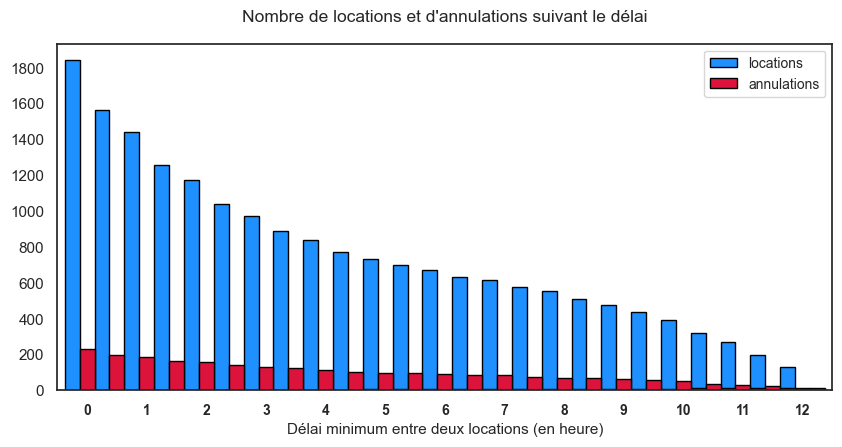

In [125]:
sns.set(rc={'figure.figsize':(10, 4.5)}, style='white')

loss_and_gain.set_index('threshold').plot(kind='bar', stacked=False, color=['dodgerblue', 'crimson'], width=1.5, edgecolor='black')

plt.title("Nombre de locations et d'annulations suivant le délai", fontsize=12.5, pad=16)
plt.xlabel('Délai minimum entre deux locations (en heure)', fontsize=11)
plt.ylabel('')

plt.yticks([i for i in range(0,1801,200)], [i for i in range(0,1801,200)], fontsize=11, fontweight='normal')
plt.xticks([i for i in range(0,25,2)], [i for i in range(0,13,1)], rotation=0, fontsize=10, fontweight='bold')

plt.legend(labels=['locations','annulations'], fontsize=10)
plt.show()

Nous séparons les données sur deux graphiques pour mieux rendre compte de l'évolution des annulations.

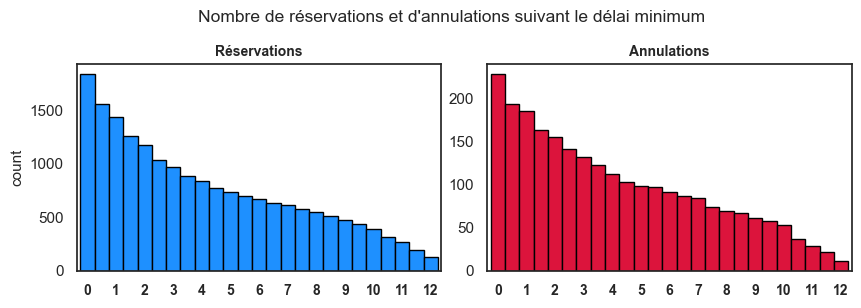

In [126]:
sns.set(rc={'figure.figsize':(10, 3)}, style='white')
fig, axes = plt.subplots(1, 2)
fig.subplots_adjust(hspace=0.125, wspace=0.125)
fig.suptitle("Nombre de réservations et d'annulations suivant le délai minimum", fontsize=12.5)
fig.subplots_adjust(top=.8)

loss_and_gain[['threshold_hour', 'total_rental']].set_index('threshold_hour').plot(kind='bar', stacked=False, color=['dodgerblue'], width=1, edgecolor='black', ax = axes[0])
loss_and_gain[['threshold_hour', 'total_cancellation']].set_index('threshold_hour').plot(kind='bar', stacked=False, color=['crimson'], width=1, edgecolor='black', ax = axes[1])

axes[0].set_title('Réservations', fontsize=10, fontweight='bold')
axes[1].set_title('Annulations', fontsize=10, fontweight='bold')

axes[0].set_xlabel('')
axes[1].set_xlabel('')

axes[0].set_ylabel('count', fontsize=11)
axes[1].set_ylabel('')

axes[0].set_xticks([i for i in range(0,25,2)], [i for i in range(0,13,1)], rotation=0, fontsize = 10, fontweight='bold')
axes[1].set_xticks([i for i in range(0,25,2)], [i for i in range(0,13,1)], rotation=0, fontsize = 10, fontweight='bold')

axes[0].legend('', frameon=False)
axes[1].legend('', frameon=False)

plt.show()

## Part de revenus des locations serrées

On assume qu'une voiture représente un loueur. Nous ne traitons pas le cas où un loueur possède plusieurs voitures.

En moyenne les locations serrées représentent 27% des revenus des loueurs.

Pour certains loueurs cette part atteint plus de la moitié des revenus, le record étant de 80%.

Ces loueurs possèdent 1087 voitures soit 13.35% du parc total.

Avec cette flotte de 13.35% ils réalisent 34% des locations (tous types confondus), soit plus du tiers.

--> Ce groupe de loueurs est donc important pour Getaround.

In [313]:
# Toutes les voitures et le nombre de locations total :
all_rentals_df = df.groupby('car_id').count()['rental_id'].to_frame().reset_index()

# Toutes les voitures et le nombre de locations à délai court :
all_cars_df = df.groupby('car_id').sum()['previous'].to_frame().reset_index()

In [314]:
# Uniquement les voitures ayant des locations serrées et le compte :
all_tight_df = all_cars_df[all_cars_df['previous'] > 0].sort_values(by='previous', ascending=False)

# Id des voitures ayant des locations serrées :
tight_car_id = all_tight_df['car_id'].unique().tolist()

# Toutes les locations de ces voitures :
tight_car_df = df[(df['car_id'].isin(tight_car_id))]

# Le nombre de locations total tous types confondus de ces voitures :
tight_rentals_count = tight_car_df['rental_id'].nunique()

# On affiche uniquement les voitures ayant des locations serrées et le compte :
all_tight_df.head()

,car_id,previous
2471,334190,15
612,241021,13
3844,365926,11
3977,368432,11
5640,392368,10


In [307]:
print('Voitures avec locations serrées :', tight_car_df['car_id'].nunique(), 'soit', round(tight_car_df['car_id'].nunique()/df['car_id'].nunique()*100,2), '% du parc total')
print('')
print('Total locations tous types confondus :', tight_rentals_count, 'soit', round(tight_rentals_count/len(df)*100,2), '% du total')
print('- dont locations serrées :', tight_car_df['previous'].sum(), 'soit', round(tight_car_df['previous'].sum()/len(df)*100,2), '% du total')
print('- dont locations non serrées :', len(tight_car_df[tight_car_df['previous']==0]), 'soit', round(len(tight_car_df[tight_car_df['previous']==0])/len(df)*100,2), '% du total')

Voitures avec locations serrées : 1087 soit 13.35 % du parc total

Total locations tous types confondus : 7255 soit 34.05 % du total
- dont locations serrées : 1841 soit 8.64 % du total
- dont locations non serrées : 5414 soit 25.41 % du total


In [244]:
owners_tight = pd.merge(all_tight_df, all_rentals_df, left_on='car_id', right_on='car_id')
owners_tight.rename(columns={'rental_id': 'total'}, inplace=True)
owners_tight['proportion'] = round(owners_tight['previous']/owners_tight['total']*100,2)

print('Part moyenne des locations serrées dans le revenu total :', round(owners_tight['proportion'].mean(),2), '%')
print('Nombre de loueurs :', len(owners_tight))
owners_tight.sort_values(by='proportion', ascending=False).head(10)

Part moyenne des locations serrées dans le revenu total : 27.48 %
Nombre de loueurs : 1087


,car_id,previous,total,proportion
68,368604,4,5,80.00
43,399575,5,7,71.43
207,383144,2,3,66.67
338,415726,2,3,66.67
327,226317,2,3,66.67
322,409088,2,3,66.67
313,307595,2,3,66.67
178,396552,2,3,66.67
311,310049,2,3,66.67
293,297119,2,3,66.67


## Impact du seuil sur les revenus

Nous fixons un seuil à 2,5 heures puis à 4 heures et nous observons l'impact sur les revenus.

### Seuil à 2,5 heures

Le nombre de réservations descend à 1040 : on perd 800 réservations.

Les loueurs concernés ne réalisent plus que 30% du revenu total, au lieu de 34%.

Pour ces loueurs ces locations ne représentent en moyenne plus que 24% de leurs revenus, au lieu de 28%.

In [404]:
# Rappel :
# tight_car_df = toutes les locations des propriétaires ayant des locations serrées

rentals_to_remove = tight_car_df[(tight_car_df['time_gap'] < 150) & (tight_car_df['previous']== 1)]['rental_id'].to_list()

new_revenue = df[~df['rental_id'].isin(rentals_to_remove)]

print('Locations restantes après application du seuil de 2,5 heures :', len(new_revenue))
print('Soit réservations perdues :', len(rentals_to_remove))
print('Nouvelle part de ces loueurs dans le groupe total :', round(len(new_revenue[new_revenue['car_id'].isin(tight_car_id)])/len(df)*100,2), '%')

Locations restantes après application du seuil de 2,5 heures : 20506
Soit réservations perdues : 803
Nouvelle part de ces loueurs dans le groupe total : 30.28 %


In [405]:
all_tight_df = new_revenue[new_revenue['car_id'].isin(tight_car_id)].groupby('car_id').sum()['previous'].to_frame().reset_index()
all_rentals_df = new_revenue.groupby('car_id').count()['rental_id'].to_frame().reset_index()

In [406]:
owners_tight = pd.merge(all_tight_df, all_rentals_df, left_on='car_id', right_on='car_id')
owners_tight.rename(columns={'rental_id': 'total'}, inplace=True)
owners_tight['proportion'] = round(owners_tight['previous']/owners_tight['total']*100,2)

print('Nouvelle part moyenne des locations serrées dans le revenu de ces loueurs :', round(owners_tight[owners_tight['previous']>0]['proportion'].mean(),2), '%')
print('Nouveau nombre de loueurs :', len(owners_tight[owners_tight['previous']>0]))
owners_tight.sort_values(by='proportion', ascending=False).head(10)

Nouvelle part moyenne des locations serrées dans le revenu de ces loueurs : 23.78 %
Nouveau nombre de loueurs : 717


,car_id,previous,total,proportion
538,368604,3,4,75.00
1085,415726,2,3,66.67
863,399575,4,6,66.67
49,223850,3,5,60.00
204,310444,4,7,57.14
981,407607,2,4,50.00
680,382968,1,2,50.00
150,295619,1,2,50.00
149,295415,1,2,50.00
363,344091,1,2,50.00


### Seuil à 4 heures

Le nombre de réservations descend à 840 : on perd 1000 réservations.

Les loueurs concernés ne réalisent plus que 29% du revenu total, au lieu de 34%.

Pour ces loueurs ces locations ne représentent en moyenne plus que 22% de leurs revenus, au lieu de 28%.

In [407]:
# Rappel :
# tight_car_df = toutes les locations des propriétaires ayant des locations serrées

rentals_to_remove = tight_car_df[(tight_car_df['time_gap'] < 240) & (tight_car_df['previous']== 1)]['rental_id'].to_list()

new_revenue = df[~df['rental_id'].isin(rentals_to_remove)]

print('Locations restantes après application du seuil de 4 heures :', len(new_revenue))
print('Soit réservations perdues :', len(rentals_to_remove))
print('Nouvelle part de ces loueurs dans le groupe total :', round(len(new_revenue[new_revenue['car_id'].isin(tight_car_id)])/len(df)*100,2), '%')

Locations restantes après application du seuil de 4 heures : 20308
Soit réservations perdues : 1001
Nouvelle part de ces loueurs dans le groupe total : 29.35 %


In [408]:
all_tight_df = new_revenue[new_revenue['car_id'].isin(tight_car_id)].groupby('car_id').sum()['previous'].to_frame().reset_index()
all_rentals_df = new_revenue.groupby('car_id').count()['rental_id'].to_frame().reset_index()

In [409]:
owners_tight = pd.merge(all_tight_df, all_rentals_df, left_on='car_id', right_on='car_id')
owners_tight.rename(columns={'rental_id': 'total'}, inplace=True)
owners_tight['proportion'] = round(owners_tight['previous']/owners_tight['total']*100,2)

print('Nouvelle part moyenne des locations serrées dans le revenu de ces loueurs :', round(owners_tight[owners_tight['previous']>0]['proportion'].mean(),2), '%')
print('Nouveau nombre de loueurs :', len(owners_tight[owners_tight['previous']>0]))
owners_tight.sort_values(by='proportion', ascending=False).head(10)

Nouvelle part moyenne des locations serrées dans le revenu de ces loueurs : 22.69 %
Nouveau nombre de loueurs : 608


,car_id,previous,total,proportion
538,368604,3,4,75.0
863,399575,3,5,60.0
853,398247,1,2,50.0
204,310444,3,6,50.0
280,327575,1,2,50.0
735,387614,1,2,50.0
41,217819,1,2,50.0
401,350904,1,2,50.0
257,320780,1,2,50.0
46,223204,1,2,50.0


## Résultats

#### Annulations : 

- On observe que 88% des locations serrées sont maintenues. Seulement 12% sont annulées.
- Cela représente 229 locations annulées.
- Parmi elles, dans 106 cas sur 229 le précédent loueur était en retard. Pour plus de la moitié des cas, le loueur précédent n'était pas en retard.
- Parmi les retards, 37 dépassaient effectivement l'heure de début de la location suivante.
- Le temps de retour moyen étant de -38 minutes soit 38 minutes en avance.
- Lorsque le retard était impactant il était en moyenne de 250 minutes soit 4h10.
- On ignore si c'est le propriétaire ou le loueur qui est à l'origine de l'annulation.

#### Délai accordé : 

- Le délai moyen accordé pour les locations serrées se situe entre 4h30 et 5h.
- Il n'y a pas de différence notable lorsqu'elles sont annulées ou maintenues.
- En moyenne le loueur précédent a rendu la voiture dans un délai de -23 minutes soit 23 minutes en avance.
- Cependant dans 48% des cas, le loueur précédant une location serrée a rendu la voiture en retard. Ce taux est supérieur à la moyenne du groupe total qui est à 44%.

#### Revenus : 

- Les locations serrées représentent en moyenne 28% des revenus des loueurs concernés
- Ces loueurs possèdent 13% du parc de voitures et réalisent 34% des locations totales
- --> Ils représentent un groupe de loueurs importants pour Getaround.

#### Seuil : 

- Fixer un seuil à **2,5 heures** permettrait de conserver **1000 réservations** et les revenus des loueurs concernés seraient **maintenus à 30%**. 
- Par ailleurs **on réduirait de moitié** le nombre de clients mécontents.
- Augmenter le seuil à **4 heures** permettrait de conserver **840 réservations** et les revenus des loueurs concernés **descendraient à 29%**. 
- Par ailleurs **on réduirait de deux tiers** le nombre de clients mécontents.
- Au-delà de **12 heures** il n'y aurait plus de locations serrées et les loueurs concernées ne contribueraient plus qu'à **un quart des revenus totaux** contre un tiers au départ.

#### Méthode de check-in : 

- Les réservations à délai court sont davantages effectuées avec des voitures Connect que dans le groupe global : 44% contre 20%.
- Cela peut s'expliquer par le fait que cette méthode n'exige pas la validation du propriétaire. Le propriétaire est susceptible de refuser une location lorsqu'il estime le délai trop court, alors que les réservations avec Connect sont automatiques et n'appliquent pas de limitation dès lors que le véhicule est affiché comme disponible.
- Les locations à délai court réservées avec la méthode Connect enregistrent plus d'annulations que celles réservées avec la méthode Mobile : 57% contre 43%.
- --> Il serait judicieux d'appliquer la nouvelle fonctionnalité uniquement sur les voitures Connect pour commencer.